## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

> In this section, we calculates proportions to thoroughly understand the concept of probabilities

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to get the same answers
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset:

In [2]:
# Read the input file and store in df
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# Check for nulls and columns datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [3]:
#Exploring the columns for unique values
df["landing_page"].unique()

array(['old_page', 'new_page'], dtype=object)

b. Use the below cell to find the number of rows in the dataset.

In [130]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [12]:
df["user_id"].nunique()

290584

In [199]:
# Identifying the duplicated user ids
df["user_id"].duplicated().sum()

3894

d. The proportion of users converted.

In [200]:
df["converted"].mean()
# or (df.query("converted == 1")["user_id"].nunique())/(df["user_id"].nunique())

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [4]:
(df[((df["group"]=='treatment') == (df["landing_page"]=='new_page')) == False])["user_id"].count()

3893

f. Do any of the rows have missing values?

In [202]:
df.info()
# Answer is NO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. So we will drop these rows

a. Create a new dataset after dropping these records and store in **df2**.

In [5]:
df2 = df.drop((df[((df["group"]=='treatment') == (df["landing_page"]=='new_page')) == False]["user_id"]).index)

In [6]:
df2.count()

user_id         290585
timestamp       290585
group           290585
landing_page    290585
converted       290585
dtype: int64

In [7]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** for working ahead

a. How many unique **user_id**s are in **df2**?

In [206]:
df2["user_id"].nunique() 

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [8]:
df2[df2["user_id"].duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [208]:
#df2.query("user_id==773192")
df2[df2["user_id"]==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [9]:
# drop index 2893
df2 = df2.drop([2893])

In [10]:
df2["user_id"].count(), df2["user_id"].nunique() 

(290584, 290584)

In [32]:
df2["timestamp"].nunique() 

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [308]:
df2["converted"].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [38]:
obs_con = df2.query("group == 'control'")["converted"].mean()

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [39]:
obs_tret = df2.query("group == 'treatment'")["converted"].mean()

In [40]:
# obs_diff
obs_diff = obs_tret - obs_con
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [12]:
df2[df2["landing_page"]=="new_page"]["user_id"].nunique() / df2["user_id"].nunique()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**From the probabilities, we see there isn't enough evidence that the new treatment page led to any more conversions. The overall conversion probability regardless of the page is ~12% and the conversion probability given an individual received either a control or a treatment page is also ~12% in each case. To confirm any disproportion in the groups, we also check for probabilty of individuals who received the new page which is 50% of the total users. This shows no evidence of treatment page improving the conversion rate**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**H0: $p_{new}$ - $p_{old}$ <= 0 <br>
H1: $p_{new}$ - $p_{old}$ > 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [15]:
p_new = df2["converted"].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null?

In [16]:
p_old = df2["converted"].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [17]:
n_new = df2.query("landing_page == 'new_page'")["user_id"].count()
n_new

145310

d. What is $n_{old}$?

In [18]:
n_old = df2.query("landing_page == 'old_page'")["user_id"].count()
n_old

145274

In [222]:
#Confirming the numbers to match
(df2["user_id"].count() == (n_new + n_old))

True

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [20]:
new_page_converted = np.random.choice([0,1], size = n_new, p=[1-p_new, p_new])
#new_page_converted.mean()

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [21]:
old_page_converted = np.random.choice([0,1], size = n_old, p=[1-p_old, p_old])
#old_page_converted.mean()

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
#Convert rate difference
p_new_sim = new_page_converted.mean()
p_old_sim = old_page_converted.mean()

sim_diff = p_new_sim - p_old_sim
sim_diff

0.0005414969817281179

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [23]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size = n_new ,p=[1-p_new, p_new], replace = True)
    old_page_converted = np.random.choice([0,1], size = n_old ,p=[1-p_old, p_old], replace = True)
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)

In [24]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

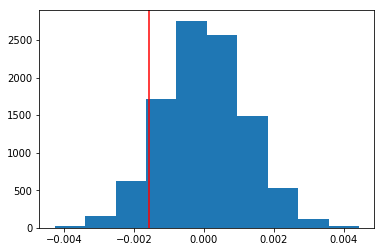

In [41]:
plt.hist(p_diffs);
plt.axvline(obs_diff, color = 'red');

**We expected the difference of conversion rate to be close to 0 for our sampling distribution and per the CLT as expected it follows a normal distribution.**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [42]:
(p_diffs > obs_diff).mean()

0.9111

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We calculated the p-value which tells us the probability of observing the statistics or one more extreme in favor of alternative hypothesis given the null hypothesis is true. In another words, it gives us the probability of how likely it is that our sample statistic value is coming from the null. Since our type-1 error threshold (alpha) is 0.05 and p-value is 0.9111 and is greater than alpha, we don't have enough statistical evidence and fail to reject the null hypothesis. Therefore, can conclude the conversion rate of new pages is less than or equal to the conversion rate of old pages.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [267]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest as pz

In [268]:
convert_old = df2.query("landing_page == 'old_page'")["converted"].sum()
convert_new = df2.query("landing_page == 'new_page'")["converted"].sum()
n_old = df2.query("landing_page == 'old_page'")["user_id"].count()
n_new = df2.query("landing_page == 'new_page'")["user_id"].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [273]:
# We are using alternative to signal the one-sided test (check for alternative hypothesis i.e. p_new - p_old > 0)
z_score, p_value = pz([convert_new, convert_old],[n_new, n_old], alternative='larger')

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [274]:
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

**There are two ways we can test a hypothesis. One is by z-score/critical value and second is using p-value.
    Z-score is calculated on a standardized normal probability distribution with a mean of 0 and standard deviation of 1. <br><br> 1) Z-score tells us how many standard deviations an element is from the mean and once calculated we can use z-table to find the percentage under curve. If this value is greater than alpha (0.05 in our case which is equivalent to a z-score of 1.645), then we reject the null hypothesis and accept if smaller. Here, 1.31 is less than 1.645 and so we fail to reject null hypothesis. <br><br> 2) P-value gives us the probability that our statistic is coming from the null or extreme value is in favor of alternative. Comparing p-value against alpha (0.05 in our case) tells us if our statistic lies in the rejection area (defined by alpha or not). If p-value is less than alpha we reject null hypothesis and fail to reject null if greater. In our case, p-value is 0.905 which is greater than 0.05 so we fail to reject null. <br><br> So our findings with z-score and p-value match and are also in agreement with result in j and k. <br> Both z-score and p-value for the conversion rates of old and new pages mean that the mean conversion rate for old pages is greater or equal to the conversion rate for new pages.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression since our response is a binomial and has only 2 outcomes.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [279]:
df2["ab_page"] = pd.get_dummies(df2["group"])["treatment"]
df2["intercept"]=1

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [280]:
# libraries statsmodels.api has already been imported in (L)
log_model = sm.Logit(df2["converted"], df2[["intercept","ab_page"]])
log_model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Apr 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:18:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

> Note: Because the variable is not significant, we do not need to take the exponential to estimate the likelihood of the odds to convert

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

**From the p-value for ab_page, we see it is not statistically significant. We therefore, fail to reject null hypothesis concluding the coefficient of ab_page is 0 and there is no relationship between group and conversion.**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**P-value associated with ab_page is 0.190 which is different from the result in Part II because this tests the statistical significance of group under a double tailed test unlike in Part II which tested it under single tailed test**

**In regression model: <br>
$H_0$: There is no relationship between convertion rate and group i.e. the coefficient of group is 0 <br>
$H_1$: Conversion rate has relationship with group i.e. the coefficient of group is not equal to 0**

**Unlike in PART II where we have designed a single tailed test, logistic regression does a double tailed test. When compared to the result from Part II we need to divide this p_value by 2 i.e. 0.19/2 = 0.095 this gives us the extreme positive and negative rejection area. To compare this value with the p-value in Part II, we need to subtract the negative extreme from the area under curve i.e. 1 - 0.095 = 0.905**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**We should add more explanatory variables to the regression model if those are correlated with the response and can help us get better predictions. We might want to be careful in doing so since it might impact our model negatively if it correlates with other explanatory varibales instead. It further sometimes even cause the Simpson's paradox, where coefficients can change, even reverse sign, because of multi-collinearity and lead to an inaccurate prediction**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [281]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [282]:
df_new.info()
df_new.country.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 834778 to 934996
Data columns (total 7 columns):
country         290584 non-null object
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
ab_page         290584 non-null uint8
intercept       290584 non-null int64
dtypes: int64(2), object(4), uint8(1)
memory usage: 15.8+ MB


array(['UK', 'US', 'CA'], dtype=object)

In [283]:
### Create the necessary dummy variables
df_new[["CA","UK","US"]] = pd.get_dummies(df_new["country"])

In [284]:
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [285]:
log_mod_c = sm.Logit(df_new["converted"], df_new[["intercept","CA","UK"]])
log_mod_c.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 16 Apr 2019   Pseudo R-squ.:               1.521e-05
Time:                        18:27:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

> Note: Because the variable is not significant, we do not need to take the exponential to estimate the likelihood of the odds to convert

**From the p-values of UK and CA, results do not seem to be statistically significant, and are very high when compared to alpha (0.05). Therefore, we fail to reject our null hypothesis that states that country has no relationship with conversion. Further, the coefficient of these variables is very close to 0 supporting the null hypothesis that it has a co-efficient of 0. As a result, we can say that country has no impact on the conversion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [286]:
### Fit Your Linear Model And Obtain the Results
df_new["ca_page"] = df_new["ab_page"]*df_new["CA"]
df_new["uk_page"] = df_new["ab_page"]*df_new["UK"]

In [287]:
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,ca_page,uk_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [288]:
log_mod_c_p = sm.Logit(df_new["converted"], df_new[["intercept","ab_page","CA","UK","ca_page","uk_page"]])
log_mod_c_p.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 16 Apr 2019   Pseudo R-squ.:               3.482e-05
Time:                        18:28:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ca_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
uk_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

> Note: Because the variable is not significant, we do not need to take the exponential to estimate the likelihood of the odds to convert

**Country, group, and the interaction doesn't seem to be statistically significant based on the p-value in our result which is very high than alpha of 0.05.**

**From all the analyses above, we saw that neither country nor group (with or without interaction) has any statistical significance on the conversion. Thinking from the practicial significance, I would as a next step want to check how long have the test been running before concluding that these variables are not significant.<br> When checked for the minimum and maximum timestamp for the duration that the test has been running for, we see it has only been 22 running for days which is too short of a time to do A/B testing on a website.**

In [289]:
df_new["timestamp"].min(), df_new["timestamp"].max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

In [290]:
#Adding another timestamp column after changing its datatype to timestam for further computations
df_new["timestamp_t"] = np.asarray(pd.to_datetime(df_new["timestamp"]))

In [293]:
#fetching days, hours, and dayofweek to use it as an explanatory variable and see the impact on conversion
df_new["day"] = df_new["timestamp_t"].dt.day
df_new["hour"] = df_new["timestamp_t"].dt.hour
df_new["dayofweek"] = df_new["timestamp_t"].dt.dayofweek

In [294]:
log_mod_t = sm.Logit(df_new["converted"], df_new[["intercept","day","hour","dayofweek"]])
log_mod_t.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366102
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 16 Apr 2019   Pseudo R-squ.:               5.302e-05
Time:                        18:32:00   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.01029
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0333      0.018   -111.726      0.000      -2.069      -1.998
day            0.0016      0.001      1.731      0.083      -0.000       0.003
hour           0.0023      0.001      2.772      0.006       0.001       0.004
dayofweek     -0.0034      0.003     -1.212      0.225      -0.009       0.002
==============================================================================
"""

In [195]:
# calculating the likelihood of conversion odds based on the coefficient of hours
# since 'hour' is the only statiscally significant variable
np.exp(0.0023)

1.002302647029

**We see that 'day' and 'day of week' does not have relationship with the convertion rate since p-value is higher than alpha and the so we fail to reject null. However, hours seems to have statistical significance with p-value of 0.006 that is less than alpha of 0.05. With the coefficient of hours, we can conclude that for every additional one hour the user spends on website there is an equal (1x) likelihood of the person getting converted holding all other variables constant.**

<a id='conclusions'></a>
## Conclusions

**From the analyses, we saw that neither country nor group (with or without interaction) has any statistical significance on the conversion. Considering that we ran the test only for 22 days, it is difficult to conclude anything. Typically the test should run for few more weeks or atleast another month in such cases. Ideally, when we design such experiments, this decision should be part of our design and set of assumptions. <br> <br> When additionally tested for days, and hours, we saw that hours have statistical significance and for every additional one hour the user spends on website there is an equal (1x) likelihood of the person getting converted holding all other variables constant. Practically also this makes sense, since the more time a user spends on the website, the more likely he would be to get converted**